In [1]:
import sys
sys.path.append('../')

from utils.dataset import  CustomDataset
import os
import warnings
warnings.filterwarnings("ignore")
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import threading
import random
# import rasterio
import os
import numpy as np
import sys
from sklearn.utils import shuffle as shuffle_lists
import numpy as np
from sklearn.model_selection import train_test_split
import joblib

import torch

#default
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

#trasnform
from torchvision import transforms
from utils.transform import *

#dataset
from utils.dataset import CustomDataset
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from torchsummary import summary
from torchsampler import ImbalancedDatasetSampler

#metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import torchmetrics.functional as tf

#numeric
import numpy as np
import pandas as pd 

#visualization
import matplotlib.pyplot as plt

#system 
from tqdm import tqdm
import os 
import wandb
import datetime


In [2]:
now = datetime.datetime.now()
formatted_now = now.strftime("%Y%m%d%H%M")
checkpoint_datetime = formatted_now
print(f"#"*30, "SAVE TIME", "#"*30)
print(f"#"*30, checkpoint_datetime, "#"*30)

############################## SAVE TIME ##############################
############################## 202403231751 ##############################


In [3]:
train_csv = '../../HDD/dataset/train_meta.csv'

train_transform = transforms.Compose([
    transforms.ToTensor(),
    RandomColorJitterTransform(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
    # ColorJitterTransform(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.1),  # Color space transformation
    RandomDropout(p=0.2),  # Random dropout
    
])
tr_batch = 88
vl_batch = 8

dataset = CustomDataset(
    csv_path= train_csv,
    transform= None, #None으로 세팅
    # transform= train_transform, #None으로 세팅
    MAX_PIXEL_VALUE= 65535,
    band = (7,6,2) #기존 세팅 
)

# 훈련 및 검증 세트 분할
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size 
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = tr_batch,
    # sampler= ImbalancedDatasetSampler(train_dataset),
    shuffle = True
)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle= False)



torch.Size([88, 3, 256, 256]) torch.Size([88, 1, 256, 256])


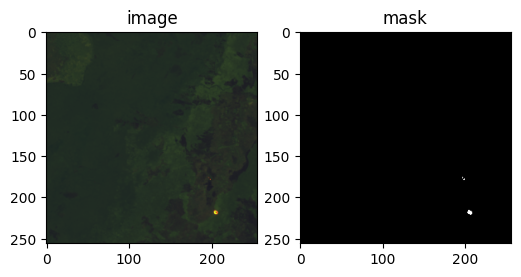

In [5]:
for images, masks in train_loader:
    print(images.shape, masks.shape)
    idx = 0
    plt.figure(figsize=(6,4))
    plt.subplot(121)
    plt.imshow(images[idx].permute(2,1,0))
    plt.title('image')
    plt.subplot(122)
    plt.imshow(masks[idx].permute(2,1,0), cmap= 'gray')
    plt.title('mask')
    plt.show()
    break

# for images, masks in valid_loader:
#     print(images.shape)
#     idx = 0
#     plt.figure(figsize=(6,4))
#     plt.subplot(121)
#     plt.imshow(images[idx])
#     plt.title('image')
#     plt.subplot(122) 
#     plt.imshow(masks[idx], cmap= 'gray')
#     plt.title('mask')
#     plt.show()
#     break

In [6]:
#model
sys.path.append('../')
from network.models import get_pretrained_model

# if torch.cuda.is_available():
#     device = 'cuda'
#     torch.cuda.manual_seed_all(42)
device = 'cuda'
# # random seed 고정
# random.seed(42)
# if torch.cuda.is_available():
#     device = torch.device('cuda')
#     torch.cuda.manual_seed_all(42)
# else:
#     device = torch.device('cuda')
#     torch.manual_seed_all(42)

# # model & cost func & optimizer 정의
############################ V1~2 #############################
# model = get_pretrained_model('unet').get()
############################ V3~4 #############################
# model = AttU_Net(img_ch= 3, output_ch= 1)
# model = get_pretrained_model('attunet').get()
# model = get_pretrained_model('r2attunet').get()
############################ V5 #############################
# model = get_pretrained_model('unet++').get()
############################ V6 #############################
# model = get_pretrained_model('manet').get()
############################ V12 #############################
model = get_pretrained_model('monai_swinunet').get()

model.to(device)

lr = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda= lambda epoch: 0.95**epoch)

loss = nn.BCEWithLogitsLoss()

print(f'device : {device}')
summary(model, input_size=(3, 256, 256))
print(f'output shape : {model(torch.randn(1,3,256,256).to(device)).shape}')

Model name : monai_swinunet
device : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 128, 128]             312
        PatchEmbed-2         [-1, 24, 128, 128]               0
           Dropout-3         [-1, 24, 128, 128]               0
         LayerNorm-4         [-1, 128, 128, 24]              48
            Linear-5               [-1, 49, 72]           1,800
           Softmax-6            [-1, 3, 49, 49]               0
           Dropout-7            [-1, 3, 49, 49]               0
            Linear-8               [-1, 49, 24]             600
           Dropout-9               [-1, 49, 24]               0
  WindowAttention-10               [-1, 49, 24]               0
         Identity-11         [-1, 128, 128, 24]               0
        LayerNorm-12         [-1, 128, 128, 24]              48
           Linear-13         [-1, 128, 128, 96]           2,4

In [7]:
metrics = {
    'tr_bce' : [],
    'vl_bce' : [],
    'tr_iou' : [],
    'vl_iou' : [],
}
epoch, epochs = 0, 200
early_stopping_epochs, early_stopping_cnt= 10, 0
SAVE_DIR = '../../satellite_model'
best_loss = float('inf')


In [15]:
def checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds, tag = False):
    # loss plot
    plt.figure(figsize=(10, 7))
    plt.subplot(121)
    plt.plot(metrics['tr_bce'], label='Train Loss')
    plt.plot(metrics['vl_bce'], label='Valid Loss')
    plt.title("BCE | DOWN GOOD")
    plt.legend()
    plt.subplot(122)
    plt.plot(metrics['tr_iou'], label='Train IoU')
    plt.plot(metrics['vl_iou'], label='Valid IoU')
    plt.title("mIOU | UP GOOD")
    plt.legend()
    plt.tight_layout()
    if tag == True:
        plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_loss.png'))
    plt.close()
    
    # mask plot
    plt.figure(figsize=(10, 7))
    plt.subplot(131)
    plt.imshow(images[0].cpu().detach().permute(2,1,0).numpy())
    plt.title('image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(masks[0].cpu().detach().permute(2,1,0).numpy(), cmap='gray')
    plt.title('mask')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(preds[0].cpu().detach().permute(2,1,0).numpy(), cmap='gray')
    plt.title('pred')
    plt.axis('off')
    plt.tight_layout()
    if tag == True:
        plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_mask.png'))
    plt.close()
    
    if tag == True:
        torch.save({
            "model" : f"{epoch}",
            "epoch" : epoch,
            "epochs" : epochs,
            "model_state_dict" : model.state_dict(),
            "optimizer_state_dict" : optimizer.state_dict(),
            "learning_rate" : lr,
            "loss" : loss,
            "metric" : metrics,
            "description" : f"segmentation model training status : {epoch}/{epochs}"
        },
        os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}.pt'))
        print(f"#"*30, f"SAVE PATH : {SAVE_DIR}", "#"*30)
    
def calculate_iou(preds, masks, threshold=0.5):
    # 예측 마스크를 이진 형태로 변환
    preds = (preds > threshold).float()
    intersection = torch.sum(preds * masks)
    union = torch.sum((preds + masks) > 0)
    iou = (intersection + 1e-7) / (union + 1e-7)  # 0으로 나누는 경우를 방지하기 위해 작은 값(1e-7)을 추가
    
    return iou

In [16]:
for epoch in tqdm(range(epoch, epochs), desc="Training Progress"):
    train_losses, valid_losses = 0., 0.
    train_ious, valid_ious = 0., 0.
    
    model.train()
    for _, (images, masks) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images, masks = images.to(device), masks.to(device)
        
        preds = model(images) 

        train_loss = loss(preds, masks).to(device)
        train_iou = calculate_iou(preds, masks).cpu().detach().numpy()
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses += train_loss.item()
        train_ious += train_iou
        break 
    scheduler.step()
    checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    
    metrics['tr_bce'].append(train_losses / len(train_loader))
    metrics['tr_iou'].append(train_ious / len(train_loader))
    print(f"Epoch : {epoch}/{epochs} | Train Loss : {train_losses / len(train_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Train IOU : {train_ious / len(train_loader)}")
    
    with torch.no_grad():
        model.eval()
        for _, (images, masks) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            images, masks = images.to(device), masks.to(device)

            preds = model(images)
            valid_loss = loss(preds, masks).to(device)
            valid_iou = calculate_iou(preds, masks).cpu().detach().numpy()
        
            valid_losses += valid_loss.item()
            valid_ious += valid_iou
            break
            

    metrics['vl_bce'].append(valid_losses / len(valid_loader))
    metrics['vl_iou'].append(valid_ious / len(valid_loader))
    print(f"Epoch : {epoch}/{epochs} | Valid Loss : {valid_losses / len(valid_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Valid IOU : {valid_ious / len(valid_loader)}")
    # Early Stopping
    if valid_losses < best_loss:
        best_loss = valid_losses
        early_stopping_cnt = 0
        # checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)

    else:
        early_stopping_cnt += 1
        if early_stopping_cnt >= early_stopping_epochs:
            print(f"Early Stops!!! : {epoch}/{epochs}")
            # checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    
    # Validation 성능이 이전보다 우수한 경우 모델 저장
    try:        
        if valid_losses > np.array(metrics['vl_bce'])[:-1].max() and epoch%10 == 0:
            pass
            # checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    except Exception as e:
        print(e)
        pass

Training Progress:   0%|          | 0/180 [00:00<?, ?it/s]

tensor(153941., device='cuda:0')
tensor(153941, device='cuda:0')


  0%|          | 0/306 [00:06<?, ?it/s]


Epoch : 20/200 | Train Loss : 0.0018362313314201006
Epoch : 20/200 | Train IOU : 2.0655565986446307e-05


Training Progress:   1%|          | 1/180 [00:06<19:43,  6.61s/it]

tensor(14094., device='cuda:0')
tensor(14094, device='cuda:0')
Epoch : 20/200 | Valid Loss : 0.0006654818852742513
Epoch : 20/200 | Valid IOU : 1.5964240412272157e-05


tensor(154712., device='cuda:0')
tensor(154712, device='cuda:0')


  0%|          | 0/306 [00:02<?, ?it/s]


Epoch : 21/200 | Train Loss : 0.0018365087072833692
Epoch : 21/200 | Train IOU : 2.215797495510843e-05


Training Progress:   1%|          | 2/180 [00:08<12:03,  4.07s/it]

tensor(13624., device='cuda:0')
tensor(13624, device='cuda:0')
Epoch : 21/200 | Valid Loss : 0.0006623083636874245
Epoch : 21/200 | Valid IOU : 1.651497358190162e-05


tensor(142838., device='cuda:0')
tensor(142838, device='cuda:0')


  0%|          | 0/306 [00:01<?, ?it/s]


Epoch : 22/200 | Train Loss : 0.0018147730749416974
Epoch : 22/200 | Train IOU : 3.365483561080266e-05


Training Progress:   2%|▏         | 3/180 [00:11<09:22,  3.18s/it]

tensor(13155., device='cuda:0')
tensor(13155, device='cuda:0')
Epoch : 22/200 | Valid Loss : 0.0006593304730596997
Epoch : 22/200 | Valid IOU : 1.6922770910674617e-05


tensor(144991., device='cuda:0')
tensor(144991, device='cuda:0')


  0%|          | 0/306 [00:02<?, ?it/s]


Epoch : 23/200 | Train Loss : 0.001814374152351828
Epoch : 23/200 | Train IOU : 2.5131152273198357e-05


Training Progress:   2%|▏         | 4/180 [00:13<08:23,  2.86s/it]

tensor(12748., device='cuda:0')
tensor(12748, device='cuda:0')
Epoch : 23/200 | Valid Loss : 0.0006565135149728684
Epoch : 23/200 | Valid IOU : 1.7463056636708122e-05


tensor(131914., device='cuda:0')
tensor(131914, device='cuda:0')


  0%|          | 0/306 [00:01<?, ?it/s]


Epoch : 24/200 | Train Loss : 0.0017973794267068502
Epoch : 24/200 | Train IOU : 4.731741995593302e-05


Training Progress:   3%|▎         | 5/180 [00:15<07:37,  2.61s/it]

tensor(12367., device='cuda:0')
tensor(12367, device='cuda:0')
Epoch : 24/200 | Valid Loss : 0.0006538660753340948
Epoch : 24/200 | Valid IOU : 1.8001055078847068e-05


tensor(130613., device='cuda:0')
tensor(130613, device='cuda:0')


  0%|          | 0/306 [00:01<?, ?it/s]


Epoch : 25/200 | Train Loss : 0.0018034655284258276
Epoch : 25/200 | Train IOU : 2.85231203960827e-05


Training Progress:   3%|▎         | 6/180 [00:17<07:00,  2.42s/it]

tensor(11989., device='cuda:0')
tensor(11989, device='cuda:0')
Epoch : 25/200 | Valid Loss : 0.0006513625383377075
Epoch : 25/200 | Valid IOU : 1.8568608599404494e-05


tensor(125014., device='cuda:0')
tensor(125014, device='cuda:0')


  0%|          | 0/306 [00:02<?, ?it/s]


Epoch : 26/200 | Train Loss : 0.0017927918169233534
Epoch : 26/200 | Train IOU : 3.223168341065544e-05


Training Progress:   4%|▍         | 7/180 [00:19<06:54,  2.39s/it]

tensor(11652., device='cuda:0')
tensor(11652, device='cuda:0')
Epoch : 26/200 | Valid Loss : 0.0006490259653046018
Epoch : 26/200 | Valid IOU : 1.9105650218469756e-05


tensor(124291., device='cuda:0')
tensor(124291, device='cuda:0')


Training Progress:   4%|▍         | 7/180 [00:21<08:58,  3.11s/it]


KeyboardInterrupt: 